In [ ]:
!kaggle datasets download -d alexteboul/diabetes-health-indicators-dataset

Dataset URL: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset
License(s): CC0-1.0
  0% 0.00/6.03M [00:00<?, ?B/s]
100% 6.03M/6.03M [00:00<00:00, 70.9MB/s]


In [ ]:
!unzip /content/diabetes-health-indicators-dataset.zip -d /content/diabetes-health-indicators-dataset

Archive:  /content/diabetes-health-indicators-dataset.zip
  inflating: /content/diabetes-health-indicators-dataset/diabetes_012_health_indicators_BRFSS2015.csv  
  inflating: /content/diabetes-health-indicators-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv  
  inflating: /content/diabetes-health-indicators-dataset/diabetes_binary_health_indicators_BRFSS2015.csv  


# import thư viện và đọc, lọc và phân chia dữ liệu từ file csv

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

In [ ]:
features = pd.read_csv('/content/diabetes-health-indicators-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

# Preprocessing

In [ ]:
# gộp
features.loc[features['Education'] < 3, 'Education'] = 3

In [ ]:
features.drop_duplicates(inplace=True)
features.reset_index(drop=True, inplace=True)

In [ ]:
# loại bỏ các dữ liệu trùng lặp
Sscaler = StandardScaler()
Rscaler = RobustScaler()
Mscaler = MinMaxScaler()
features_standardized = pd.DataFrame(Sscaler.fit_transform(features), columns=features.columns)
features_robust = pd.DataFrame(Rscaler.fit_transform(features), columns=features.columns)
features_MinMax = pd.DataFrame(Mscaler.fit_transform(features), columns=features.columns)



features[['BMI', 'Age', 'GenHlth']] = features_standardized[['BMI', 'Age', 'GenHlth']]
features[['MentHlth', 'PhysHlth']] = features_robust[['MentHlth', 'PhysHlth']]
features[['Education', 'Income']] = features_MinMax[['Education', 'Income']]

In [ ]:
features

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,-0.553426,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.123058,1.666667,5.000000,0.0,1.0,-1.610757,1.000000,1.000000
1,0.0,1.0,1.0,1.0,-0.553426,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.123058,0.000000,0.000000,0.0,1.0,1.188163,1.000000,1.000000
2,0.0,0.0,0.0,1.0,-0.553426,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,-1.682092,0.000000,1.666667,0.0,1.0,1.538027,1.000000,1.000000
3,0.0,1.0,1.0,1.0,-0.273626,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.123058,0.000000,0.500000,0.0,1.0,0.838298,1.000000,1.000000
4,0.0,0.0,0.0,1.0,-0.133727,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,-0.779517,0.000000,0.000000,0.0,0.0,-0.211297,0.666667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69050,1.0,0.0,1.0,1.0,0.985471,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.025633,0.000000,0.000000,0.0,0.0,-0.911027,0.333333,0.000000
69051,1.0,0.0,1.0,1.0,-0.133727,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,-0.779517,0.000000,0.000000,1.0,1.0,0.488433,0.000000,0.714286
69052,1.0,1.0,1.0,1.0,-0.693325,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.928207,5.000000,0.000000,1.0,0.0,1.538027,1.000000,0.428571
69053,1.0,1.0,1.0,1.0,-1.672623,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.025633,0.000000,0.000000,1.0,0.0,0.838298,0.000000,0.428571


# Sử dụng gridSearchCV tìm tham số tốt nhất

In [ ]:
class_0 = features[features['Diabetes_binary'] == 0]
class_1 = features[features['Diabetes_binary'] == 1]

x_class_0, y_class_0 = class_0.drop(columns=['Diabetes_binary'], axis=1), class_0['Diabetes_binary']
x_class_1, y_class_1 = class_1.drop(columns=['Diabetes_binary'], axis=1), class_1['Diabetes_binary']

x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_class_0, y_class_0, test_size=0.2, random_state=1)
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_class_1, y_class_1, test_size=0.2, random_state=1)

x_0_train, x_0_val, y_0_train, y_0_val = train_test_split(x_0_train, y_0_train, test_size=0.25, random_state=1)
x_1_train, x_1_val, y_1_train, y_1_val = train_test_split(x_1_train, y_1_train, test_size=0.25, random_state=1)



x_train = pd.concat(objs=[x_0_train, x_1_train], ignore_index=True).to_numpy()
y_train = pd.concat(objs=[y_0_train, y_1_train], ignore_index=True).to_numpy()
index = np.arange(x_train.shape[0])
np.random.shuffle(index)
x_train = x_train[index]
y_train = y_train[index]

x_val = pd.concat(objs=[x_0_val, x_1_val], ignore_index=True).to_numpy()
y_val = pd.concat(objs=[y_0_val, y_1_val], ignore_index=True).to_numpy()
index = np.arange(x_val.shape[0])
np.random.shuffle(index)
x_val = x_val[index]
y_val = y_val[index]

x_test = pd.concat(objs=[x_0_test, x_1_test], ignore_index=True).to_numpy()
y_test = pd.concat(objs=[y_0_test, y_1_test], ignore_index=True).to_numpy()
index = np.arange(x_test.shape[0])
np.random.shuffle(index)
x_test = x_test[index]
y_test = y_test[index]

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 39),
    'random_state': [42],
    'min_impurity_decrease': np.arange(start=0.00009, stop=0.00014, step=0.000002)
}

model = DecisionTreeClassifier()

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    verbose=3,
    n_jobs=-1
)

grid_search.fit(x_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
optimal = grid_search.best_params_

Fitting 5 folds for each of 5700 candidates, totalling 28500 fits
Best parameters: {'criterion': 'gini', 'max_depth': 9, 'min_impurity_decrease': 0.00010999999999999995, 'random_state': 42, 'splitter': 'best'}
Best score: 0.7324371250937484


In [ ]:
optimal

{'criterion': 'gini',
 'max_depth': 9,
 'min_impurity_decrease': 0.00010999999999999995,
 'random_state': 42,
 'splitter': 'best'}

In [ ]:
decisionTree = DecisionTreeClassifier(criterion='gini', splitter='best', min_impurity_decrease=0.00011, max_depth=9, random_state=42)
decisionTree.fit(X=x_train, y=y_train)
y_pred = decisionTree.predict(X=x_val)
print(f1_score(y_val, y_pred, average='macro'))

0.7355154374023667


# Khảo sát mức độ quan trọng của các thuộc tính

In [ ]:
class_0 = features[features['Diabetes_binary'] == 0]
class_1 = features[features['Diabetes_binary'] == 1]

x_class_0, y_class_0 = class_0.drop(columns=['Diabetes_binary'], axis=1), class_0['Diabetes_binary']
x_class_1, y_class_1 = class_1.drop(columns=['Diabetes_binary'], axis=1), class_1['Diabetes_binary']

x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_class_0, y_class_0, test_size=0.2, random_state=1)
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_class_1, y_class_1, test_size=0.2, random_state=1)

x_0_train, x_0_val, y_0_train, y_0_val = train_test_split(x_0_train, y_0_train, test_size=0.25, random_state=1)
x_1_train, x_1_val, y_1_train, y_1_val = train_test_split(x_1_train, y_1_train, test_size=0.25, random_state=1)



x_train = pd.concat(objs=[x_0_train, x_1_train], ignore_index=True).to_numpy()
y_train = pd.concat(objs=[y_0_train, y_1_train], ignore_index=True).to_numpy()
index = np.arange(x_train.shape[0])
np.random.shuffle(index)
x_train = x_train[index]
y_train = y_train[index]

x_val = pd.concat(objs=[x_0_val, x_1_val], ignore_index=True).to_numpy()
y_val = pd.concat(objs=[y_0_val, y_1_val], ignore_index=True).to_numpy()
index = np.arange(x_val.shape[0])
np.random.shuffle(index)
x_val = x_val[index]
y_val = y_val[index]

x_test = pd.concat(objs=[x_0_test, x_1_test], ignore_index=True).to_numpy()
y_test = pd.concat(objs=[y_0_test, y_1_test], ignore_index=True).to_numpy()
index = np.arange(x_test.shape[0])
np.random.shuffle(index)
x_test = x_test[index]
y_test = y_test[index]

In [ ]:
decisionTree = DecisionTreeClassifier(criterion='gini', splitter='best', min_impurity_decrease=0.00011, max_depth=9, random_state=42)
decisionTree.fit(X=x_train, y=y_train)

DecisionTreeClassifier(max_depth=9, min_impurity_decrease=0.00011,
                       random_state=42)

In [ ]:
featureColumn = []
means = []
std = []
perm_importance = permutation_importance(estimator=decisionTree, X=x_val, y=y_val, scoring='f1_macro', n_repeats=100, random_state=42)
for i in perm_importance.importances_mean.argsort()[::-1]:
    featureColumn.append(features.columns[i+1])
    means.append(perm_importance.importances_mean[i])
    std.append(perm_importance.importances_std[i])

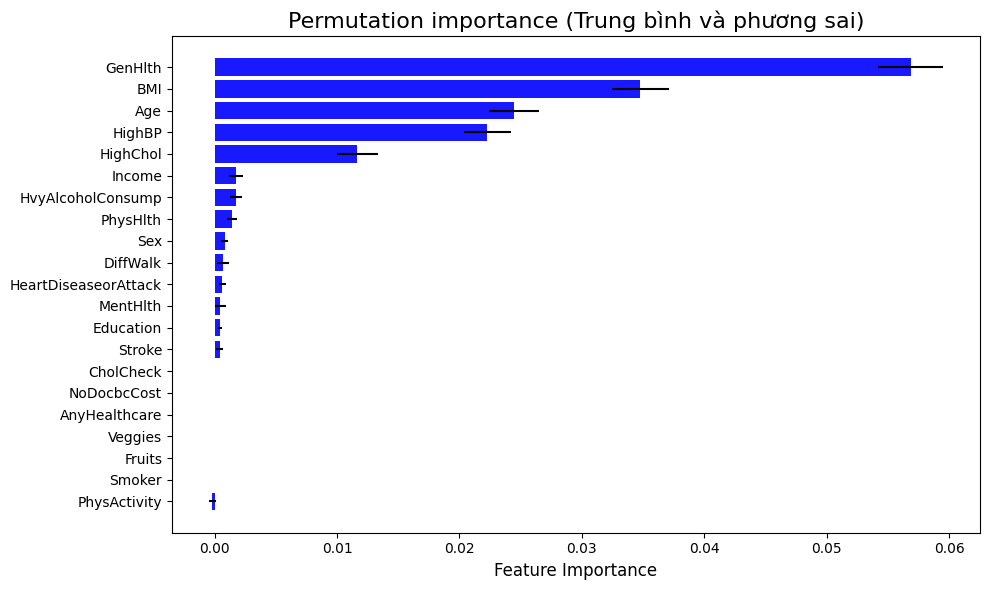

In [ ]:
sorted_indices = np.argsort(means)[::-1]
features_sorted = [featureColumn[i] for i in sorted_indices]
importance_sorted = [means[i] for i in sorted_indices]
std_sorted = [std[i] for i in sorted_indices]
plt.figure(figsize=(10, 6))
plt.barh(features_sorted, importance_sorted, xerr=std_sorted, color='blue', alpha=0.9)
plt.gca().invert_yaxis()  # Đảo ngược trục y để giá trị cao nhất ở trên cùng
plt.title("Permutation importance (Trung bình và phương sai)", fontsize=16)
plt.xlabel("Feature Importance", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
decisionTree = DecisionTreeClassifier(criterion='gini', splitter='best', min_impurity_decrease=0.00011, max_depth=9, random_state=42)
decisionTree.fit(X=x_train, y=y_train)

DecisionTreeClassifier(max_depth=9, min_impurity_decrease=0.00011,
                       random_state=42)

In [ ]:
res = permutation_importance(estimator=decisionTree, X=x_val, y=y_val, scoring='f1_macro', n_repeats=100, random_state=42)
columns = features.columns.drop(labels='Diabetes_binary')
result = pd.DataFrame({'Name': columns, 'importances_mean': res.importances_mean, 'importances_std': res.importances_std})
result.sort_values(by='importances_mean', ascending=False, inplace=True)
print(result)

                    Name  importances_mean  importances_std
13               GenHlth          0.056873         0.002649
3                    BMI          0.034787         0.002351
18                   Age          0.024456         0.002073
0                 HighBP          0.022264         0.001929
1               HighChol          0.011667         0.001666
20                Income          0.001769         0.000556
10     HvyAlcoholConsump          0.001736         0.000503
15              PhysHlth          0.001436         0.000412
17                   Sex          0.000819         0.000315
16              DiffWalk          0.000696         0.000486
6   HeartDiseaseorAttack          0.000631         0.000263
14              MentHlth          0.000473         0.000482
19             Education          0.000416         0.000163
5                 Stroke          0.000404         0.000282
8                 Fruits          0.000000         0.000000
9                Veggies          0.0000

In [ ]:
columns = list(result.Name[0:14])
columns.append('Diabetes_binary')
print(len(columns))

15


# Xây dựng lại tập train | test

In [ ]:
class_0 = features[features['Diabetes_binary'] == 0][columns]
class_1 = features[features['Diabetes_binary'] == 1][columns]

x_class_0, y_class_0 = class_0.drop(columns=['Diabetes_binary'], axis=1), class_0['Diabetes_binary']
x_class_1, y_class_1 = class_1.drop(columns=['Diabetes_binary'], axis=1), class_1['Diabetes_binary']

x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_class_0, y_class_0, test_size=0.2, random_state=1)
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_class_1, y_class_1, test_size=0.2, random_state=1)

x_train = pd.concat(objs=[x_0_train, x_1_train], ignore_index=True).to_numpy()
y_train = pd.concat(objs=[y_0_train, y_1_train], ignore_index=True).to_numpy()
index = np.arange(x_train.shape[0])
np.random.shuffle(index)
x_train = x_train[index]
y_train = y_train[index]

x_test = pd.concat(objs=[x_0_test, x_1_test], ignore_index=True).to_numpy()
y_test = pd.concat(objs=[y_0_test, y_1_test], ignore_index=True).to_numpy()
index = np.arange(x_test.shape[0])
np.random.shuffle(index)
x_test = x_test[index]
y_test = y_test[index]

In [ ]:
decisionTree = DecisionTreeClassifier(criterion='gini', splitter='best', min_impurity_decrease=0.00011, max_depth=9, random_state=42)
decisionTree.fit(X=x_train, y=y_train)
decisionTree.score(X=x_train, y=y_train)
y_pred = decisionTree.predict(X=x_test)
f1_macro = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print('f1: ', f1_macro)
print('acc: ', acc)

f1:  0.739863826266492
acc:  0.7399898631525595


In [ ]:
class_0 = features[features['Diabetes_binary'] == 0]
class_1 = features[features['Diabetes_binary'] == 1]

x_class_0, y_class_0 = class_0.drop(columns=['Diabetes_binary'], axis=1), class_0['Diabetes_binary']
x_class_1, y_class_1 = class_1.drop(columns=['Diabetes_binary'], axis=1), class_1['Diabetes_binary']

x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_class_0, y_class_0, test_size=0.2, random_state=1)
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_class_1, y_class_1, test_size=0.2, random_state=1)

x_train = pd.concat(objs=[x_0_train, x_1_train], ignore_index=True).to_numpy()
y_train = pd.concat(objs=[y_0_train, y_1_train], ignore_index=True).to_numpy()
index = np.arange(x_train.shape[0])
np.random.shuffle(index)
x_train = x_train[index]
y_train = y_train[index]

x_test = pd.concat(objs=[x_0_test, x_1_test], ignore_index=True).to_numpy()
y_test = pd.concat(objs=[y_0_test, y_1_test], ignore_index=True).to_numpy()
index = np.arange(x_test.shape[0])
np.random.shuffle(index)
x_test = x_test[index]
y_test = y_test[index]

In [ ]:
decisionTree = DecisionTreeClassifier(criterion='gini', splitter='best', min_impurity_decrease=0.00011, max_depth=9, random_state=42)
decisionTree.fit(X=x_train, y=y_train)
decisionTree.score(X=x_train, y=y_train)
y_pred = decisionTree.predict(X=x_test)
f1_macro = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print('f1: ', f1_macro)
print('acc: ', acc)

f1:  0.7395854206591547
acc:  0.7397002389399754
